# Regressions

This notebook summarizes our regressions in olipol settings.

In [1]:
# Imports
import polars as pl

DATA_PATH = "../data/results/all_experiments.parquet"

## Fish et al. Table 2

Here we replicate the results from Fish et al. (2025) table 2, which is a regression of price on lagged price and lagged competitor price, with firm fixed effects.

In [2]:
# Load duopoly
df = (
    pl.read_parquet(DATA_PATH)
    .filter((pl.col("num_agents") == 2) & (pl.col("is_symmetric")))
    .with_columns(
        (pl.col("experiment_timestamp").rank("dense")).alias("run_id"),
        (pl.col("agent").rank("dense")).alias("firm_id"),
        pl.col("chosen_price").truediv(pl.col("alpha")).alias("price"),
    )
    .rename(
        {
            "round": "period",
            "price": "price",
            "agent_prefix_type": "prompt_prefix",
        }
    )
    .select(["period", "run_id", "firm_id", "price", "prompt_prefix"])
)

In [3]:
import polars as pl
import pandas as pd
from statsmodels.formula.api import ols

# Assuming your dataframe has columns:
# period, run_id, firm_id, price, prompt_prefix, competitor_price


def reproduce_table2_regression(df):
    """
    Reproduce Table 2 regression from Fish et al. (2025)
    Model: p^t_{i,r} = α_{i,r} + γp^{t-1}_{i,r} + δp^{t-1}_{-i,r} + ε^t_{i,r}
    """

    # Filter to periods 101-300 only
    df_filtered = df.filter((pl.col("period") >= 100) & (pl.col("period") <= 300))

    # Create disjoint pairs and alternate firms
    regression_data = []

    for prompt in ["P1", "P2"]:
        prompt_data = df_filtered.filter(pl.col("prompt_prefix") == prompt)

        for run_id in prompt_data["run_id"].unique():
            run_data = prompt_data.filter(pl.col("run_id") == run_id)

            # Get available periods and create disjoint pairs
            periods = sorted(run_data["period"].unique().to_list())

            # Create pairs: (101,102), (103,104), (105,106), etc.
            period_pairs = [
                (periods[i], periods[i + 1]) for i in range(0, len(periods) - 1, 2)
            ]

            for pair_idx, (t1, t2) in enumerate(period_pairs):
                # Alternate which firm is "self" between consecutive pairs
                if pair_idx % 2 == 0:
                    self_firm = 1
                    competitor_firm = 2
                else:
                    self_firm = 2
                    competitor_firm = 1

                # Get data for period t2 (current) and t1 (lag)
                current_data = run_data.filter(
                    (pl.col("period") == t2) & (pl.col("firm_id") == self_firm)
                )
                lag_data = run_data.filter(
                    (pl.col("period") == t1) & (pl.col("firm_id") == self_firm)
                )
                # The competitor price is found by looking up the other firm's data:
                competitor_lag_data = run_data.filter(
                    (pl.col("period") == t1) & (pl.col("firm_id") == competitor_firm)
                )

                if (
                    len(current_data) == 1
                    and len(lag_data) == 1
                    and len(competitor_lag_data) == 1
                ):
                    regression_data.append(
                        {
                            "prompt": prompt,
                            "run_id": run_id,
                            "firm_id": self_firm,
                            "period": t2,
                            "price": current_data["price"].item(),
                            "price_lag": lag_data["price"].item(),
                            "competitor_price_lag": competitor_lag_data["price"].item(),
                            "firm_run": f"{self_firm}_{run_id}",
                        }
                    )

    # Convert to pandas for statsmodels
    reg_df = pd.DataFrame(regression_data)

    results = {}

    # Run separate regressions for P1 and P2
    for prompt in ["P1", "P2"]:
        prompt_data = reg_df[reg_df["prompt"] == prompt].copy()

        # Add firm-run fixed effects using categorical variable
        prompt_data["firm_run_cat"] = pd.Categorical(prompt_data["firm_run"])
        # Add firm fixed effects using categorical variable
        prompt_data["firm_id_cat"] = pd.Categorical(prompt_data["firm_id"])

        global df_pd
        df_pd = prompt_data

        # Run regression with fixed effects
        # Using C() for categorical fixed effects
        # formula = "price ~ price_lag + competitor_price_lag + C(firm_run_cat)"
        # Run regression with fixed effects
        # Using C() for categorical fixed effects (firm fixed effects, not firm-run)
        formula = "price ~ price_lag + competitor_price_lag + C(firm_id_cat)"
        model = ols(formula, data=prompt_data).fit(cov_type="HC1")  # HC1 for robust SEs

        print(100 * "-")
        print(f"\n{prompt} vs {prompt} Results:")

        print(model.summary())

        results[prompt] = {
            "model": model,
            "self_coef": model.params["price_lag"],
            "self_se": model.bse["price_lag"],
            "competitor_coef": model.params["competitor_price_lag"],
            "competitor_se": model.bse["competitor_price_lag"],
            "n_obs": len(prompt_data),
            "r_squared": model.rsquared,
        }

        print(f"\n{prompt} vs {prompt} Results:")
        print(
            f"Self t-1: {results[prompt]['self_coef']:.3f} ({results[prompt]['self_se']:.3f})"
        )
        print(
            f"Competitor t-1: {results[prompt]['competitor_coef']:.3f} ({results[prompt]['competitor_se']:.3f})"
        )
        print(f"N: {results[prompt]['n_obs']}")
        print(f"R²: {results[prompt]['r_squared']:.3f}")

    return results, reg_df


# Run the analysis
results, regression_data = reproduce_table2_regression(df)


print(results)

----------------------------------------------------------------------------------------------------

P1 vs P1 Results:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.788e+05
Date:                Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                        18:40:47   Log-Likelihood:                 6986.8
No. Observations:                2100   AIC:                        -1.397e+04
Df Residuals:                    2096   BIC:                        -1.394e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-

## Main regression + Robustness checks

- Baseline
- With alpha controls
- With different time horizons
- Log vs Level prices
- Non-linearities

In [4]:
import polars as pl
import numpy as np


class FolkAnalysis:
    """Analysis with robustness checks for Folk Theorem testing"""

    def __init__(self, df):
        self.df = df

    def preprocess_data(self, last_periods, use_log_prices=True):
        """Clean preprocessing with configurable period window and log transformation"""

        processed_df = (
            self.df.filter((pl.col("num_agents") > 1) & (pl.col("is_symmetric")))
            .filter(pl.col("round") >= (301 - last_periods))  # Last N periods
            .with_columns(
                [
                    pl.col("experiment_timestamp").rank("dense").alias("run_id"),
                    pl.col("num_agents").alias("group_size"),
                    pl.col("agent_prefix_type").alias("prompt_type"),
                    pl.col("alpha").alias("alpha"),
                ]
            )
        )

        if use_log_prices:
            processed_df = processed_df.with_columns(
                (pl.col("chosen_price") / pl.col("alpha")).log().alias("price")
            )
        else:
            processed_df = processed_df.with_columns(
                (pl.col("chosen_price") / pl.col("alpha")).alias("price")
            )

        return processed_df.select(
            ["run_id", "group_size", "prompt_type", "price", "alpha"]
        ).to_pandas()

    def run_regression(self, last_periods, use_log_prices=True, is_main=False):
        """Run single regression specification"""

        if is_main:
            print("MAIN REGRESSION (Last 50 periods, log prices)")
            print("=" * 50)
        else:
            price_type = "log prices" if use_log_prices else "level prices"
            print(f"ROBUSTNESS CHECK: Last {last_periods} periods, {price_type}")
            print("-" * 50)

        # Get data
        processed_df = self.preprocess_data(last_periods, use_log_prices)

        # Collapse to run-level averages
        run_data = (
            processed_df.groupby(["run_id", "group_size", "prompt_type", "alpha"])
            .agg({"price": "mean"})
            .reset_index()
        )

        # Add squared and interaction terms
        run_data["group_size_sq"] = run_data["group_size"] ** 2
        run_data["group_size_x_p2"] = run_data["group_size"] * (
            run_data["prompt_type"] == "P2"
        ).astype(int)

        if is_main:
            # For main analysis, run multiple specifications
            print("Without alpha controls:")
            model_linear = ols(
                "price ~ group_size + C(prompt_type)", data=run_data
            ).fit(cov_type="HC3")
            print(model_linear.summary())

            print("\nWith alpha controls:")
            model_linear_alpha = ols(
                "price ~ group_size + C(prompt_type) + C(alpha)", data=run_data
            ).fit(cov_type="HC3")
            print(model_linear_alpha.summary())

            print("\nWith squared terms:")
            model_squared = ols(
                "price ~ group_size + group_size_sq + C(prompt_type) + C(alpha)",
                data=run_data,
            ).fit(cov_type="HC3")
            print(model_squared.summary())

            print("\nWith interaction effects:")
            model_interaction = ols(
                "price ~ group_size + C(prompt_type) + group_size_x_p2 + C(alpha)",
                data=run_data,
            ).fit(cov_type="HC3")
            print(model_interaction.summary())
            print()

            return model_linear_alpha
        else:
            # For robustness checks, just run with alpha controls
            model_linear_alpha = ols(
                "price ~ group_size + C(prompt_type) + C(alpha)", data=run_data
            ).fit(cov_type="HC3")

            print(model_linear_alpha.summary())
            print()

            return model_linear_alpha

    def run_all_analyses(self):
        """Execute main regression plus all robustness checks"""

        # Main regression
        main_model = self.run_regression(50, use_log_prices=True, is_main=True)

        # Robustness checks - different period windows
        for periods in [25, 75, 100]:
            self.run_regression(periods, use_log_prices=True, is_main=False)

        # Robustness check - without log prices
        self.run_regression(50, use_log_prices=False, is_main=False)

        return main_model

In [5]:
df = pl.read_parquet(DATA_PATH).filter(
    (pl.col("num_agents") > 1) & (pl.col("is_symmetric"))
)

In [6]:
analysis = FolkAnalysis(df)

In [7]:
main_model = analysis.run_all_analyses()

MAIN REGRESSION (Last 50 periods, log prices)
Without alpha controls:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     196.0
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           2.55e-44
Time:                        18:40:47   Log-Likelihood:                 187.29
No. Observations:                 168   AIC:                            -368.6
Df Residuals:                     165   BIC:                            -359.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

### Convergence analysis

In [8]:
"""
IMPROVED Rigorous Statistical Analysis for Folk Theorem Testing
==============================================================

Key improvements:
1. More realistic convergence definition for survival analysis
2. Better rolling window parameters
3. Multiple robustness checks
4. Focus on economically meaningful outcomes
"""

import polars as pl
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from lifelines import KaplanMeierFitter, CoxPHFitter
import warnings

warnings.filterwarnings("ignore")


class ImprovedCollusionAnalysis:
    """
    Improved statistically rigorous analysis with better convergence definitions
    """

    def __init__(self, df):
        self.df = df
        self.results = {}

    def preprocess_data(self):
        """Clean data preprocessing"""
        print("📊 PREPROCESSING DATA")
        print("=" * 50)

        # Filter and clean data
        self.processed_df = (
            self.df.filter((pl.col("num_agents") > 1) & (pl.col("is_symmetric")))
            .filter(pl.col("round") >= 251)  # Final 50 periods only
            .with_columns(
                [
                    # Log prices for regression stability
                    (pl.col("chosen_price") / pl.col("alpha")).log().alias("log_price"),
                    (pl.col("monopoly_prices") / pl.col("alpha"))
                    .log()
                    .alias("log_monopoly"),
                    (pl.col("nash_prices") / pl.col("alpha")).log().alias("log_nash"),
                    # Price levels (for convergence analysis)
                    (pl.col("chosen_price") / pl.col("alpha")).alias("norm_price"),
                    (pl.col("monopoly_prices") / pl.col("alpha")).alias(
                        "norm_monopoly"
                    ),
                    (pl.col("nash_prices") / pl.col("alpha")).alias("norm_nash"),
                    # Clean identifiers
                    pl.col("experiment_timestamp").rank("dense").alias("run_id"),
                    pl.col("agent").rank("dense").alias("agent_id"),
                    pl.col("num_agents").alias("group_size"),
                    pl.col("agent_prefix_type").alias("prompt_type"),
                    pl.col("round").alias("period"),
                ]
            )
            .select(
                [
                    "run_id",
                    "agent_id",
                    "period",
                    "group_size",
                    "prompt_type",
                    "log_price",
                    "log_monopoly",
                    "log_nash",
                    "norm_price",
                    "norm_monopoly",
                    "norm_nash",
                    "alpha",
                ]
            )
        ).to_pandas()

        print(f"✓ Final dataset: {len(self.processed_df):,} observations")
        print(f"✓ Group sizes: {sorted(self.processed_df['group_size'].unique())}")
        return self.processed_df

    def analysis_1_structural_break_tests(self):
        """ANALYSIS 1: Structural break testing (same as before but cleaner)"""
        print("\n🔍 ANALYSIS 1: STRUCTURAL BREAK TESTING")
        print("=" * 60)

        # Collapse to run-level averages
        run_data = (
            self.processed_df.groupby(["run_id", "group_size", "prompt_type"])
            .agg(
                {
                    "log_price": "mean",
                    "norm_price": "mean",
                    "norm_monopoly": "mean",
                    "norm_nash": "mean",
                }
            )
            .reset_index()
        )

        print(
            f"Run-level data: {len(run_data)} runs across {len(run_data['group_size'].unique())} group sizes"
        )

        # Test for threshold effects
        group_sizes = sorted(run_data["group_size"].unique())
        possible_thresholds = group_sizes[1:-1]
        threshold_results = []

        for threshold in possible_thresholds:
            run_data[f"threshold_{threshold}"] = (
                run_data["group_size"] <= threshold
            ).astype(int)
            formula = f"log_price ~ threshold_{threshold} + C(prompt_type)"
            model = ols(formula, data=run_data).fit()

            threshold_results.append(
                {
                    "threshold": threshold,
                    "ssr": model.ssr,
                    "threshold_coef": model.params[f"threshold_{threshold}"],
                    "threshold_tstat": model.tvalues[f"threshold_{threshold}"],
                    "threshold_pval": model.pvalues[f"threshold_{threshold}"],
                    "r_squared": model.rsquared,
                }
            )

        threshold_df = pd.DataFrame(threshold_results)
        optimal_idx = threshold_df["ssr"].idxmin()
        optimal_threshold = threshold_df.loc[optimal_idx, "threshold"]
        sup_tstat = threshold_df["threshold_tstat"].abs().max()

        print("\n📊 THRESHOLD ANALYSIS:")
        print(f"  Optimal threshold: n ≤ {optimal_threshold}")
        print(f"  Supremum t-statistic: {sup_tstat:.3f}")

        if sup_tstat > 3.0:
            print("✓ Strong evidence of threshold effect")
        elif sup_tstat > 2.5:
            print("○ Moderate evidence of threshold effect")
        else:
            print("× Weak evidence of threshold effect")

        # Final linear model
        formula = "log_price ~ group_size + C(prompt_type)"
        final_model = ols(formula, data=run_data).fit()

        print("\n📊 LINEAR MODEL RESULTS:")
        print(f"  Group size coefficient: {final_model.params['group_size']:.4f}")
        print(f"  T-statistic: {final_model.tvalues['group_size']:.3f}")
        print(f"  P-value: {final_model.pvalues['group_size']:.3f}")
        print(f"  R-squared: {final_model.rsquared:.3f}")

        self.results["structural_breaks"] = {
            "threshold_results": threshold_df,
            "optimal_threshold": optimal_threshold,
            "supremum_tstat": sup_tstat,
            "final_model": final_model,
            "run_data": run_data,
        }

        return run_data, final_model

    def analysis_2_improved_survival_analysis(self):
        """ANALYSIS 2: Improved survival analysis with better convergence definition"""
        print("\n⚰️ ANALYSIS 2: IMPROVED SURVIVAL ANALYSIS")
        print("=" * 60)

        convergence_data = []

        # Define multiple convergence criteria
        print("📊 TESTING MULTIPLE CONVERGENCE DEFINITIONS:")

        for run_id in self.processed_df["run_id"].unique():
            run_df = self.processed_df[self.processed_df["run_id"] == run_id].copy()
            run_df = run_df.sort_values("period")

            group_size = run_df["group_size"].iloc[0]
            prompt_type = run_df["prompt_type"].iloc[0]

            # Calculate price statistics
            run_df["price_change"] = run_df["norm_price"].diff().abs()
            run_df["price_variance"] = (
                run_df["norm_price"].rolling(window=5, min_periods=1).var()
            )

            # Convergence Definition 1: Low variance (more realistic)
            variance_threshold = 0.01  # Much more lenient
            min_stable_periods = 5  # Shorter window

            convergence_period_1 = None
            for i in range(len(run_df) - min_stable_periods):
                if (
                    run_df["price_variance"].iloc[i : i + min_stable_periods].max()
                    < variance_threshold
                ):
                    convergence_period_1 = run_df["period"].iloc[i]
                    break

            # Convergence Definition 2: Price stability (alternative)
            change_threshold = 0.02  # More lenient than before
            convergence_period_2 = None
            for i in range(len(run_df) - min_stable_periods):
                if (
                    run_df["price_change"].iloc[i : i + min_stable_periods].max()
                    < change_threshold
                ):
                    convergence_period_2 = run_df["period"].iloc[i]
                    break

            # Use the more lenient definition (variance-based)
            convergence_period = convergence_period_1

            # Create survival data
            max_period = run_df["period"].max()
            if convergence_period is not None:
                duration = convergence_period - run_df["period"].min()
                event_observed = 1
            else:
                duration = max_period - run_df["period"].min()
                event_observed = 0

            convergence_data.append(
                {
                    "run_id": run_id,
                    "group_size": group_size,
                    "prompt_type": prompt_type,
                    "duration": duration,
                    "event_observed": event_observed,
                    "convergence_period": convergence_period,
                    "final_price_variance": run_df["price_variance"].iloc[-5:].mean(),
                    "mean_price": run_df["norm_price"].mean(),
                }
            )

        survival_df = pd.DataFrame(convergence_data)
        convergence_rate = survival_df["event_observed"].mean()

        print(f"  Convergence rate (variance-based): {convergence_rate:.1%}")
        print("  Events by group size:")
        event_summary = survival_df.groupby("group_size")["event_observed"].agg(
            ["sum", "count"]
        )
        for gs in sorted(survival_df["group_size"].unique()):
            events = event_summary.loc[gs, "sum"]
            total = event_summary.loc[gs, "count"]
            print(f"    Group {gs}: {events}/{total} ({events / total:.1%})")

        # Only proceed with survival analysis if we have reasonable event rates
        if convergence_rate < 0.1:
            print("\n⚠️ CONVERGENCE RATE TOO LOW FOR RELIABLE SURVIVAL ANALYSIS")
            print("Switching to alternative outcome: Price Stability Analysis")

            # Alternative: Use final period price variance as outcome
            stability_data = survival_df.copy()
            stability_data["high_stability"] = (
                stability_data["final_price_variance"]
                < stability_data["final_price_variance"].median()
            ).astype(int)

            print("\n📊 PRICE STABILITY ANALYSIS:")
            stability_by_group = stability_data.groupby("group_size")[
                "high_stability"
            ].agg(["mean", "count"])
            for gs in sorted(stability_data["group_size"].unique()):
                rate = stability_by_group.loc[gs, "mean"]
                n = stability_by_group.loc[gs, "count"]
                print(f"  Group {gs}: {rate:.1%} high stability (n={n})")

            # Statistical test for stability differences
            from scipy.stats import chi2_contingency

            stability_crosstab = pd.crosstab(
                stability_data["group_size"], stability_data["high_stability"]
            )
            chi2, p_val, dof, expected = chi2_contingency(stability_crosstab)
            print(
                f"\nChi-square test for stability differences: χ²={chi2:.3f}, p={p_val:.3f}"
            )

            self.results["survival_analysis"] = {
                "convergence_rate": convergence_rate,
                "survival_data": survival_df,
                "stability_analysis": stability_data,
                "stability_test": {"chi2": chi2, "p_value": p_val},
                "analysis_type": "stability_based",
            }

            return survival_df, None, stability_data

        else:
            # Proceed with traditional survival analysis
            print("\n📊 KAPLAN-MEIER SURVIVAL ANALYSIS:")

            plt.figure(figsize=(12, 8))
            group_sizes = sorted(survival_df["group_size"].unique())

            for group_size in group_sizes:
                group_data = survival_df[survival_df["group_size"] == group_size]
                if (
                    group_data["event_observed"].sum() > 0
                ):  # Only plot if there are events
                    kmf = KaplanMeierFitter()
                    kmf.fit(
                        group_data["duration"],
                        group_data["event_observed"],
                        label=f"Group Size {group_size}",
                    )
                    kmf.plot_survival_function(ax=plt.gca())

                    median_survival = kmf.median_survival_time_
                    events = group_data["event_observed"].sum()
                    total = len(group_data)
                    print(
                        f"  Group {group_size}: median={median_survival:.1f}, events={events}/{total}"
                    )

            plt.title("Kaplan-Meier Survival Curves: Time to Price Convergence")
            plt.xlabel("Periods to Convergence")
            plt.ylabel("Survival Probability (Non-convergence)")
            plt.legend()
            plt.show()

            # Cox model if sufficient events
            if survival_df["event_observed"].sum() >= 10:
                cox_data = survival_df.copy()
                cox_data["prompt_P1"] = (cox_data["prompt_type"] == "P1").astype(int)

                cph = CoxPHFitter()
                cph.fit(
                    cox_data[["duration", "event_observed", "group_size", "prompt_P1"]],
                    duration_col="duration",
                    event_col="event_observed",
                )

                print("\n📊 COX PROPORTIONAL HAZARDS:")
                group_size_hr = np.exp(cph.params_["group_size"])
                group_size_p = cph.summary.loc["group_size", "p"]
                print(
                    f"  Group size hazard ratio: {group_size_hr:.3f} (p={group_size_p:.3f})"
                )

                self.results["survival_analysis"] = {
                    "convergence_rate": convergence_rate,
                    "survival_data": survival_df,
                    "cox_model": cph,
                    "group_size_hazard_ratio": group_size_hr,
                    "analysis_type": "survival_based",
                }

                return survival_df, cph, None
            else:
                print("Insufficient events for Cox regression")
                self.results["survival_analysis"] = {
                    "convergence_rate": convergence_rate,
                    "survival_data": survival_df,
                    "analysis_type": "insufficient_events",
                }
                return survival_df, None, None

    def analysis_3_improved_stability_tests(self):
        """ANALYSIS 3: Improved parameter stability with better window sizing"""
        print("\n📈 ANALYSIS 3: IMPROVED PARAMETER STABILITY")
        print("=" * 50)

        # Use run-level data for stability testing
        run_data = self.results["structural_breaks"]["run_data"]
        print(f"Using {len(run_data)} run-level observations")

        # Test 1: Temporal stability (split sample)
        print("\n📊 TEMPORAL STABILITY TEST:")
        n_runs = len(run_data)
        split_point = n_runs // 2

        early_runs = run_data.iloc[:split_point]
        late_runs = run_data.iloc[split_point:]

        if len(early_runs) >= 10 and len(late_runs) >= 10:
            formula = "log_price ~ group_size + C(prompt_type)"
            model_early = ols(formula, data=early_runs).fit()
            model_late = ols(formula, data=late_runs).fit()
            model_pooled = ols(formula, data=run_data).fit()

            # Chow test
            k = len(model_pooled.params)
            n1, n2 = len(early_runs), len(late_runs)

            chow_stat = (
                (model_pooled.ssr - (model_early.ssr + model_late.ssr)) / k
            ) / ((model_early.ssr + model_late.ssr) / (n1 + n2 - 2 * k))
            chow_pval = 1 - stats.f.cdf(chow_stat, k, n1 + n2 - 2 * k)

            print(f"  Chow test: F={chow_stat:.3f}, p={chow_pval:.3f}")
            print(
                f"  Early period group effect: {model_early.params['group_size']:.4f}"
            )
            print(f"  Late period group effect: {model_late.params['group_size']:.4f}")

            if chow_pval < 0.05:
                print("⚠️ Parameter instability detected")
            else:
                print("✓ Parameters stable across time")

        # Test 2: Bootstrap stability test
        print("\n📊 BOOTSTRAP STABILITY TEST:")
        n_bootstrap = 1000
        bootstrap_coefs = []

        np.random.seed(42)
        for i in range(n_bootstrap):
            bootstrap_sample = run_data.sample(n=len(run_data), replace=True)
            try:
                model = ols(
                    "log_price ~ group_size + C(prompt_type)", data=bootstrap_sample
                ).fit()
                bootstrap_coefs.append(model.params["group_size"])
            except:
                continue

        if len(bootstrap_coefs) > 100:
            bootstrap_coefs = np.array(bootstrap_coefs)
            coef_mean = bootstrap_coefs.mean()
            coef_std = bootstrap_coefs.std()
            coef_ci_lower = np.percentile(bootstrap_coefs, 2.5)
            coef_ci_upper = np.percentile(bootstrap_coefs, 97.5)

            print(f"  Bootstrap results (n={len(bootstrap_coefs)}):")
            print(f"  Mean coefficient: {coef_mean:.4f}")
            print(f"  Standard error: {coef_std:.4f}")
            print(f"  95% CI: [{coef_ci_lower:.4f}, {coef_ci_upper:.4f}]")

            # Stability assessment
            relative_se = (
                coef_std / abs(coef_mean) if abs(coef_mean) > 0.001 else np.inf
            )
            if relative_se < 0.1:
                stability_assessment = "high_stability"
                print("✓ High parameter stability (rel. SE < 0.1)")
            elif relative_se < 0.2:
                stability_assessment = "moderate_stability"
                print("○ Moderate parameter stability (rel. SE < 0.2)")
            else:
                stability_assessment = "low_stability"
                print("⚠️ Low parameter stability (rel. SE ≥ 0.2)")
        else:
            stability_assessment = "insufficient_data"
            print("Insufficient bootstrap samples")

        # Test 3: Heteroskedasticity test
        print("\n📊 HETEROSKEDASTICITY TEST:")
        final_model = self.results["structural_breaks"]["final_model"]
        bp_stat, bp_pval, _, _ = het_breuschpagan(
            final_model.resid, final_model.model.exog
        )
        print(f"  Breusch-Pagan test: LM={bp_stat:.3f}, p={bp_pval:.3f}")

        if bp_pval < 0.05:
            print("⚠️ Heteroskedasticity detected")
            robust_model = ols(
                "log_price ~ group_size + C(prompt_type)", data=run_data
            ).fit(cov_type="HC3")
            preferred_model = robust_model
            print("  Using robust standard errors")
        else:
            print("✓ Homoskedasticity assumption satisfied")
            preferred_model = final_model

        self.results["stability_tests"] = {
            "temporal_stability": {"chow_stat": chow_stat, "chow_pval": chow_pval}
            if "chow_stat" in locals()
            else None,
            "bootstrap_stability": {
                "mean_coef": coef_mean if "coef_mean" in locals() else None,
                "std_error": coef_std if "coef_std" in locals() else None,
                "confidence_interval": [coef_ci_lower, coef_ci_upper]
                if "coef_ci_lower" in locals()
                else None,
                "relative_se": relative_se if "relative_se" in locals() else None,
            },
            "heteroskedasticity": {"bp_stat": bp_stat, "bp_pval": bp_pval},
            "final_model": preferred_model,
            "stability_assessment": stability_assessment,
        }

        return preferred_model

    def create_comprehensive_summary(self):
        """Create final summary"""
        print("\n📋 COMPREHENSIVE SUMMARY")
        print("=" * 50)

        structural = self.results.get("structural_breaks", {})
        survival = self.results.get("survival_analysis", {})
        stability = self.results.get("stability_tests", {})

        print("🔍 STRUCTURAL ANALYSIS:")
        if structural:
            model = structural["final_model"]
            group_coef = model.params["group_size"]
            group_p = model.pvalues["group_size"]
            print(f"  Group size effect: {group_coef:.4f} (p={group_p:.3f})")
            print(
                f"  Threshold evidence: supremum t = {structural['supremum_tstat']:.3f}"
            )

        print("\n⚰️ CONVERGENCE/STABILITY ANALYSIS:")
        if survival:
            analysis_type = survival["analysis_type"]
            if analysis_type == "stability_based":
                stability_test = survival["stability_test"]
                print("  Analysis type: Price stability (convergence rate too low)")
                print(
                    f"  Stability differences: χ²={stability_test['chi2']:.3f}, p={stability_test['p_value']:.3f}"
                )
            elif analysis_type == "survival_based":
                hr = survival["group_size_hazard_ratio"]
                print("  Analysis type: Survival analysis")
                print(f"  Group size hazard ratio: {hr:.3f}")

        print("\n📈 PARAMETER STABILITY:")
        if stability:
            assessment = stability["stability_assessment"]
            print(f"  Stability assessment: {assessment}")

            bootstrap = stability["bootstrap_stability"]
            if bootstrap["relative_se"] is not None:
                print(f"  Bootstrap relative SE: {bootstrap['relative_se']:.3f}")

        # Final conclusion
        print("\n🎯 OVERALL ASSESSMENT:")
        evidence_count = 0

        # Evidence 1: Structural breaks
        if structural and structural["supremum_tstat"] > 2.5:
            evidence_count += 1
            print("✓ Structural break evidence supports group size effects")

        # Evidence 2: Main effect significance
        if structural and structural["final_model"].pvalues["group_size"] < 0.05:
            evidence_count += 1
            print("✓ Linear model shows significant group size effect")

        # Evidence 3: Stability/survival evidence
        if survival:
            if survival["analysis_type"] == "stability_based":
                if survival["stability_test"]["p_value"] < 0.05:
                    evidence_count += 1
                    print("✓ Price stability differs significantly by group size")
            elif (
                survival["analysis_type"] == "survival_based"
                and "cox_model" in survival
            ):
                cox_p = survival["cox_model"].summary.loc["group_size", "p"]
                if cox_p < 0.05:
                    evidence_count += 1
                    print("✓ Survival analysis supports group size effects")

        print(f"\nEvidence strength: {evidence_count}/3 tests significant")

        if evidence_count >= 2:
            conclusion = "STRONG EVIDENCE"
        elif evidence_count == 1:
            conclusion = "MODERATE EVIDENCE"
        else:
            conclusion = "LIMITED EVIDENCE"

        print(f"CONCLUSION: {conclusion} for Folk Theorem effects")

        return {
            "evidence_score": evidence_count,
            "conclusion": conclusion,
            "structural_breaks": structural,
            "survival_analysis": survival,
            "stability_tests": stability,
        }

    def run_improved_analysis(self):
        """Execute improved analysis"""
        print("🎯 IMPROVED FOLK THEOREM ANALYSIS")
        print("=" * 60)
        print("Improvements: Better convergence definition, robustness checks")
        print()

        self.preprocess_data()

        # Three analyses
        run_data, structural_model = self.analysis_1_structural_break_tests()
        survival_data, cox_model, stability_data = (
            self.analysis_2_improved_survival_analysis()
        )
        stability_model = self.analysis_3_improved_stability_tests()

        # Summary
        final_summary = self.create_comprehensive_summary()

        return self.results, final_summary

In [9]:
analysis = ImprovedCollusionAnalysis(df)

🎯 IMPROVED FOLK THEOREM ANALYSIS
Improvements: Better convergence definition, robustness checks

📊 PREPROCESSING DATA
✓ Final dataset: 29,400 observations
✓ Group sizes: [np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

🔍 ANALYSIS 1: STRUCTURAL BREAK TESTING
Run-level data: 168 runs across 4 group sizes

📊 THRESHOLD ANALYSIS:
  Optimal threshold: n ≤ 3
  Supremum t-statistic: 6.280
✓ Strong evidence of threshold effect

📊 LINEAR MODEL RESULTS:
  Group size coefficient: -0.0373
  T-statistic: -6.757
  P-value: 0.000
  R-squared: 0.666

⚰️ ANALYSIS 2: IMPROVED SURVIVAL ANALYSIS
📊 TESTING MULTIPLE CONVERGENCE DEFINITIONS:
  Convergence rate (variance-based): 66.7%
  Events by group size:
    Group 2: 39/42 (92.9%)
    Group 3: 26/42 (61.9%)
    Group 4: 25/42 (59.5%)
    Group 5: 22/42 (52.4%)

📊 KAPLAN-MEIER SURVIVAL ANALYSIS:
  Group 2: median=0.0, events=39/42
  Group 3: median=2.0, events=26/42
  Group 4: median=0.0, events=25/42
  Group 5: median=10.0, events=22/42


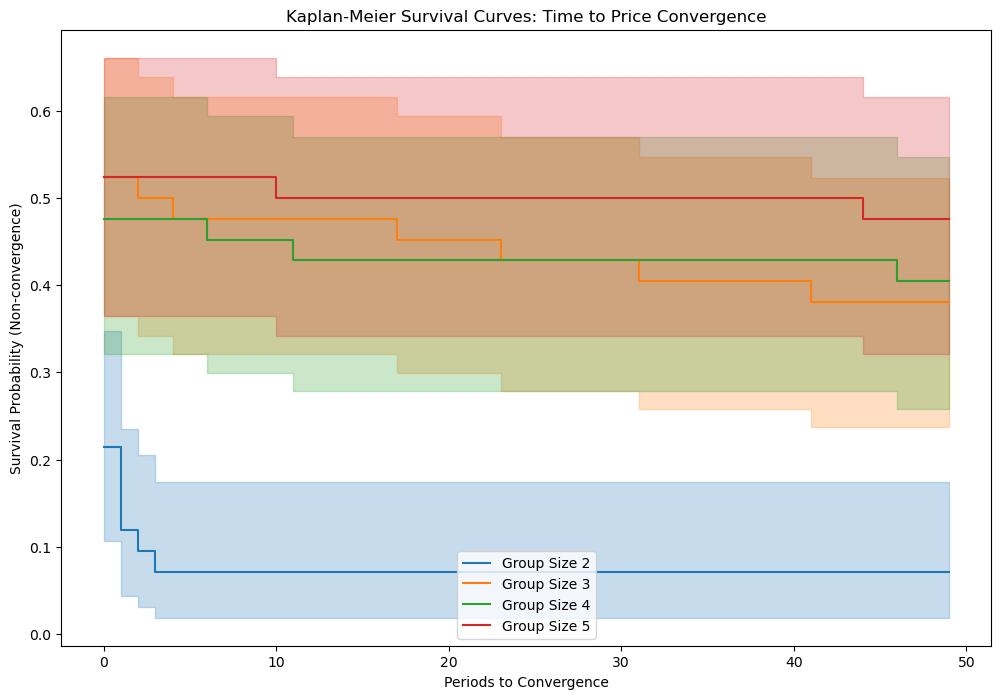


📊 COX PROPORTIONAL HAZARDS:
  Group size hazard ratio: 0.731 (p=0.001)

📈 ANALYSIS 3: IMPROVED PARAMETER STABILITY
Using 168 run-level observations

📊 TEMPORAL STABILITY TEST:
  Chow test: F=1.545, p=0.205
  Early period group effect: -0.0305
  Late period group effect: -0.0495
✓ Parameters stable across time

📊 BOOTSTRAP STABILITY TEST:
  Bootstrap results (n=1000):
  Mean coefficient: -0.0373
  Standard error: 0.0056
  95% CI: [-0.0477, -0.0261]
○ Moderate parameter stability (rel. SE < 0.2)

📊 HETEROSKEDASTICITY TEST:
  Breusch-Pagan test: LM=18.453, p=0.000
⚠️ Heteroskedasticity detected
  Using robust standard errors

📋 COMPREHENSIVE SUMMARY
🔍 STRUCTURAL ANALYSIS:
  Group size effect: -0.0373 (p=0.000)
  Threshold evidence: supremum t = 6.280

⚰️ CONVERGENCE/STABILITY ANALYSIS:
  Analysis type: Survival analysis
  Group size hazard ratio: 0.731

📈 PARAMETER STABILITY:
  Stability assessment: moderate_stability
  Bootstrap relative SE: 0.150

🎯 OVERALL ASSESSMENT:
✓ Structural bre

({'structural_breaks': {'threshold_results':    threshold       ssr  threshold_coef  threshold_tstat  threshold_pval  \
   0          3  1.090228        0.078765         6.279755    2.891727e-09   
   1          4  1.191071        0.071208         4.703898    5.367478e-06   
   
      r_squared  
   0   0.656240  
   1   0.624443  ,
   'optimal_threshold': np.int64(3),
   'supremum_tstat': np.float64(6.279755072864792),
   'final_model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x26b50312550>,
   'run_data':      run_id  group_size prompt_type  log_price  norm_price  norm_monopoly  \
   0         1           2          P1   0.533046    1.704540       1.924981   
   1         2           2          P2   0.400066    1.492020       1.924981   
   2         3           2          P1   0.523745    1.688402       1.924981   
   3         4           2          P2   0.409371    1.506250       1.924981   
   4         5           2          P1   0.485207    1.624947    

In [10]:
analysis.run_improved_analysis()

## Testing and discovery: Group size effect

This part of the notebook is exploratory  - ignore.

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import sys

import polars as pl

sys.path.append(os.path.abspath(".."))

from src.analysis.group_size import CollusionAnalysis, run_analysis

In [2]:
DATA_PATH = "../data/results/all_experiments.parquet"

df = pl.read_parquet(DATA_PATH)

In [3]:
df = (
    pl.read_parquet(DATA_PATH)
    .filter((pl.col("num_agents") > 1) & (pl.col("is_symmetric")))
    .rename(
        {
            "experiment_timestamp": "run_id",
            "agent": "agent_id",
            "round": "period",
            "price": "price",
            "agent_prefix_type": "prompt_type",
            "num_agents": "group_size",
            "chosen_price": "price",
        }
    )
    .select(
        [
            "period",
            "run_id",
            "agent_id",
            "price",
            "prompt_type",
            "group_size",
            "profit",
            "alpha",
            "monopoly_prices",
            "nash_prices",
        ]
    )
)

In [4]:
# Run everything in one go
def run_analysis(df: pl.DataFrame):
    """
    Complete analysis pipeline with dynamic benchmarks
    """
    # Initialize analysis
    analysis = CollusionAnalysis(df)

    # Preprocess data
    analysis.preprocess_data(start_period=101, end_period=300)

    # Create interleaved data to handle autocorrelation
    analysis.create_interleaved_data(interval=2)

    # Run all regressions
    analysis.estimate_group_size_effects()
    analysis.estimate_nonlinear_effects()
    analysis.estimate_threshold_effects(threshold=3)
    analysis.estimate_prompt_interactions()
    analysis.convergence_analysis(final_periods=50)

    # Run-level analysis (most appropriate for group size effects)
    analysis.estimate_run_level_ols()

    # Calculate metrics and visualize
    analysis.calculate_collusion_metrics()
    analysis.plot_results()

    # Print summary
    analysis.print_summary()

    return analysis

In [5]:
# Initialize analysis
analysis = CollusionAnalysis(df)

✓ Data validation passed. Shape: (176400, 10)
✓ Benchmark price relationships appear valid (monopoly > nash)
✓ Stored raw benchmarks for 56 group sizes
Raw benchmark prices by group size:
shape: (56, 4)
┌────────────┬─────────────────┬─────────────┬───────┐
│ group_size ┆ monopoly_prices ┆ nash_prices ┆ alpha │
│ ---        ┆ ---             ┆ ---         ┆ ---   │
│ i64        ┆ f64             ┆ f64         ┆ f64   │
╞════════════╪═════════════════╪═════════════╪═══════╡
│ 2          ┆ 6.159939        ┆ 4.713365    ┆ 3.2   │
│ 2          ┆ 19.249811       ┆ 14.729267   ┆ 10.0  │
│ 2          ┆ 6.159939        ┆ 4.713365    ┆ 3.2   │
│ 2          ┆ 1.924981        ┆ 1.472929    ┆ 1.0   │
│ 2          ┆ 19.249811       ┆ 14.729267   ┆ 10.0  │
│ …          ┆ …               ┆ …           ┆ …     │
│ 5          ┆ 20.972312       ┆ 13.115207   ┆ 10.0  │
│ 5          ┆ 20.972312       ┆ 13.115207   ┆ 10.0  │
│ 5          ┆ 2.097231        ┆ 1.31152     ┆ 1.0   │
│ 5          ┆ 20.972312   

In [6]:
# Preprocess data
analysis.preprocess_data(start_period=101, end_period=300)

✓ All prices normalized by alpha at observation level
✓ Preprocessing complete. Analysis periods: 101-300


period,run_id,agent_id,price,prompt_type,group_size,profit,alpha,monopoly_prices,nash_prices,price_log_normalized,monopoly_prices_log_normalized,nash_prices_log_normalized,run_numeric,agent_numeric,prompt_numeric,price_analysis,monopoly_analysis,nash_analysis
i64,str,str,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,f64,f64,f64
101,"""1751280484""","""Firm A""",1.655,"""P1""",4,40.41,1.0,2.054411,1.331461,0.503801,0.719989,0.286277,0,0,0,0.503801,0.719989,0.286277
102,"""1751280484""","""Firm A""",1.655,"""P1""",4,40.34,1.0,2.054411,1.331461,0.503801,0.719989,0.286277,0,0,0,0.503801,0.719989,0.286277
103,"""1751280484""","""Firm A""",1.655,"""P1""",4,40.2,1.0,2.054411,1.331461,0.503801,0.719989,0.286277,0,0,0,0.503801,0.719989,0.286277
104,"""1751280484""","""Firm A""",1.655,"""P1""",4,40.17,1.0,2.054411,1.331461,0.503801,0.719989,0.286277,0,0,0,0.503801,0.719989,0.286277
105,"""1751280484""","""Firm A""",1.655,"""P1""",4,40.18,1.0,2.054411,1.331461,0.503801,0.719989,0.286277,0,0,0,0.503801,0.719989,0.286277
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
296,"""1751091046""","""Firm B""",15.605,"""P2""",2,28.31,10.0,19.249811,14.729267,0.445006,0.654916,0.387251,167,1,1,0.445006,0.654916,0.387251
297,"""1751091046""","""Firm B""",15.605,"""P2""",2,28.31,10.0,19.249811,14.729267,0.445006,0.654916,0.387251,167,1,1,0.445006,0.654916,0.387251
298,"""1751091046""","""Firm B""",15.605,"""P2""",2,28.33,10.0,19.249811,14.729267,0.445006,0.654916,0.387251,167,1,1,0.445006,0.654916,0.387251


In [7]:
# Create interleaved data to handle autocorrelation
analysis.create_interleaved_data(interval=2)

✓ Sophisticated interleaved data created with agent rotation
  - Total observations: 16800
  - Runs included: 168
  - Period pairs processed: ~100 per run
  - Group size distribution:
    Group size 2: 4200 observations
    Group size 3: 4200 observations
    Group size 4: 4200 observations
    Group size 5: 4200 observations


run_id,prompt_type,agent_id,focal_agent_position,period,group_size,n_competitors,price_analysis,monopoly_analysis,nash_analysis,price_analysis_lag,competitor_price_analysis_lag,competitor_price_analysis_std,run_numeric,agent_numeric,prompt_numeric,agent_run
str,str,str,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str
"""1751207955""","""P2""","""Firm A""",0,102,3,2,0.598837,0.693147,0.31493,0.604316,0.362831,0.012175,69,0,1,"""Firm A_1751207955"""
"""1751207955""","""P2""","""Firm B""",1,104,3,2,0.350657,0.693147,0.31493,0.350657,0.484166,0.10916,69,1,1,"""Firm B_1751207955"""
"""1751207955""","""P2""","""Firm C""",2,106,3,2,0.375006,0.693147,0.31493,0.375006,0.462903,0.119313,69,2,1,"""Firm C_1751207955"""
"""1751207955""","""P2""","""Firm A""",0,108,3,2,0.553885,0.693147,0.31493,0.565314,0.355739,0.019267,69,0,1,"""Firm A_1751207955"""
"""1751207955""","""P2""","""Firm B""",1,110,3,2,0.336472,0.693147,0.31493,0.336472,0.461564,0.086558,69,1,1,"""Firm B_1751207955"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""1751097501""","""P1""","""Firm C""",2,292,3,2,0.474991,0.693147,0.31493,0.474369,0.411316,0.052418,56,2,0,"""Firm C_1751097501"""
"""1751097501""","""P1""","""Firm A""",0,294,3,2,0.357674,0.693147,0.31493,0.358723,0.469673,0.005939,56,0,0,"""Firm A_1751097501"""
"""1751097501""","""P1""","""Firm B""",1,296,3,2,0.465933,0.693147,0.31493,0.465619,0.416867,0.059367,56,1,0,"""Firm B_1751097501"""


Same observation numbers per group as we altercate the group size. This is done to ensure that the group size effect is not confounded by the number of observations. We average across all competitors in the group except for the one we are interested in.

CONVERGENCE ANALYSIS - FIXED SPECIFICATION

1. TIME EFFECTS ONLY (Proper for time-invariant treatments)
--------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:         price_analysis   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     14.17
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           1.73e-39
Time:                        01:49:48   Log-Likelihood:                 20198.
No. Observations:               29400   AIC:                        -4.029e+04
Df Residuals:                   29348   BIC:                        -3.986e+04
Df Model:                          51                                         
Covariance Type:              cluster                                         
                              coef    std err          

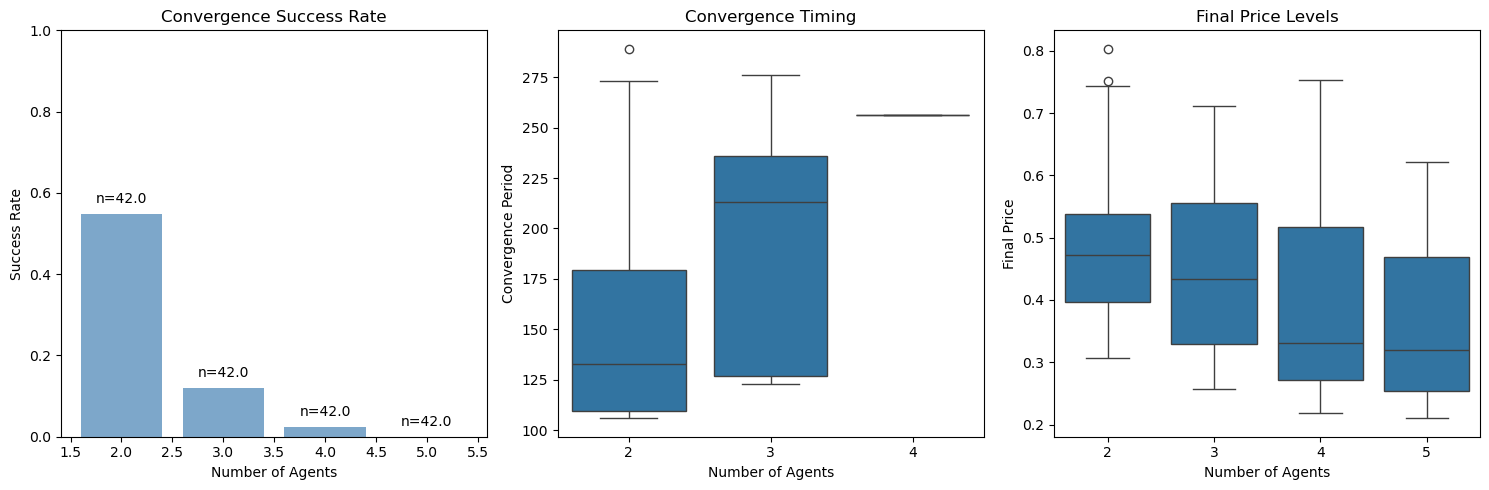

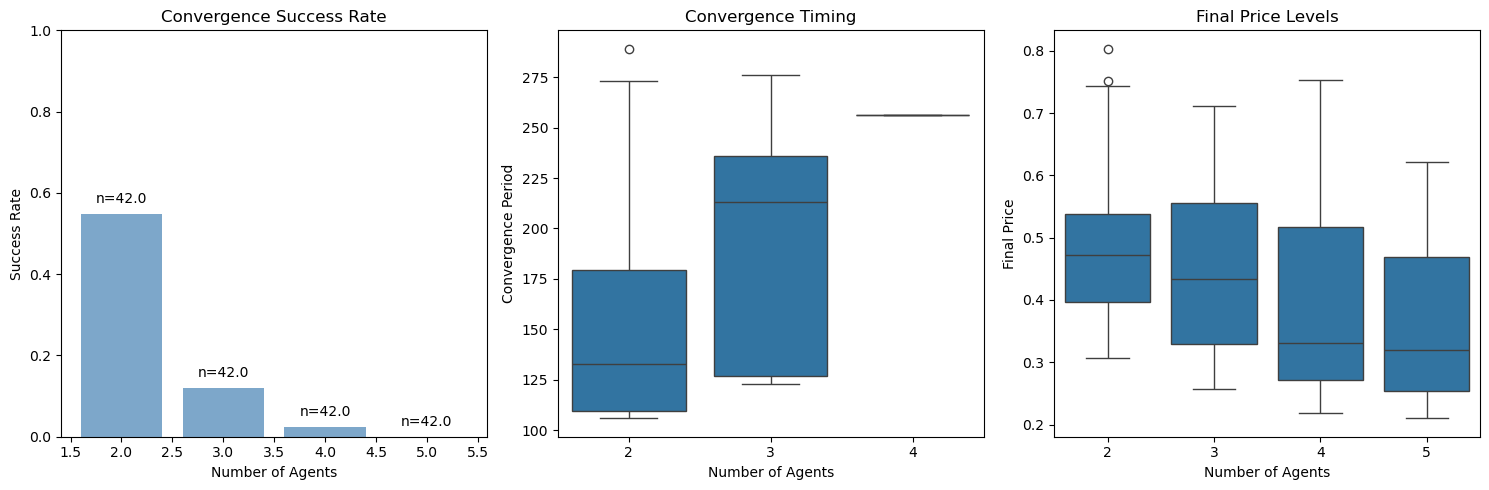

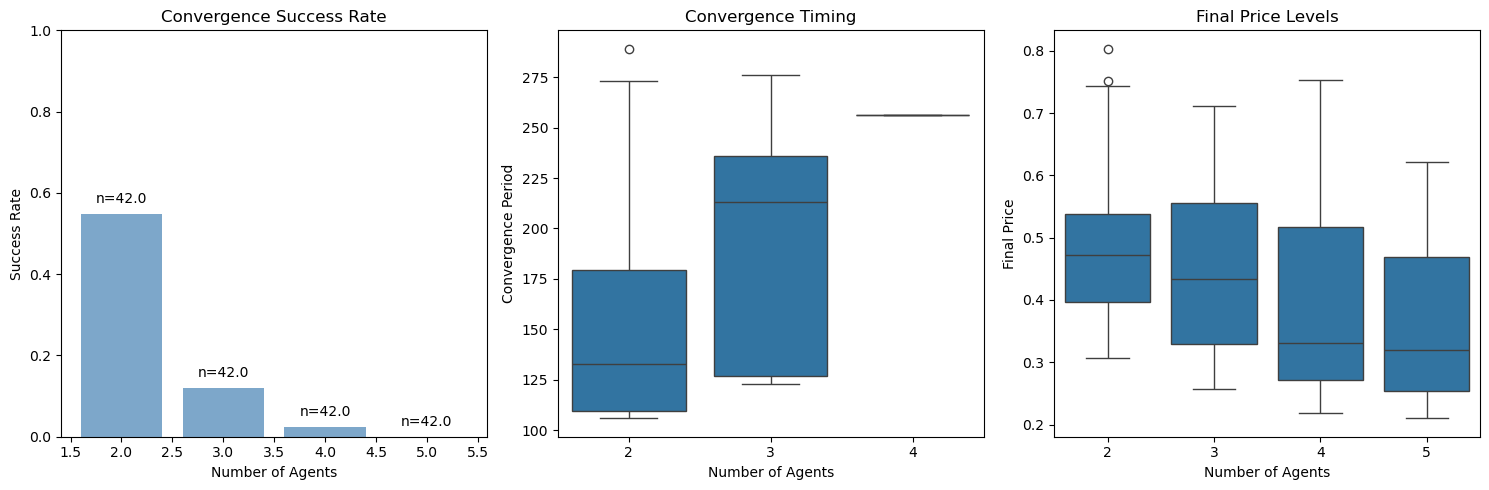

In [8]:
analysis.convergence_analysis_fixed()

# Add the simple convergence test
convergence_results = analysis.simple_convergence_test()
analysis.plot_simple_convergence(convergence_results)

In [9]:
# Run all regressions
analysis.estimate_group_size_effects()

✓ Using sophisticated interleaved data with lagged variables
✓ Main regressions estimated (time FE and agent-level) with lags


(                          PanelOLS Estimation Summary                           
 Dep. Variable:         price_analysis   R-squared:                        0.9978
 Estimator:                   PanelOLS   R-squared (Between):              1.0000
 No. Observations:               16800   R-squared (Within):               0.9932
 Date:                Thu, Jul 03 2025   R-squared (Overall):              0.9997
 Time:                        01:49:52   Log-likelihood                 5.735e+04
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                   1.934e+06
 Entities:                         168   P-value                           0.0000
 Avg Obs:                      100.000   Distribution:                 F(4,16696)
 Min Obs:                      100.000                                           
 Max Obs:                      100.000   F-statistic (robust):          2.348e+06
                

⚠️ THIS changes completely when interleaving is conducted but no firm level altercation (or averaging if n>2). Needs further analysis - cf. [group_size.py](../src/analysis/group_size.py)⚠️

## 1. Main Time FE with Lags
**Model Specification**: 
```
price_analysis_it = β₁group_size_i + β₂prompt_type_i + β₃price_analysis_lag_it + β₄competitor_price_lag_it + γₜ + εᵢₜ
```
*Panel data with time fixed effects (γₜ), clustered standard errors by run*

**Dynamic Panel Asks**: *"Given last period's prices, does group size affect this period's price adjustment?"*  
**Answer**: No, because 99.7% price persistence dominates all other effects.

**Key Findings**:
- **Group size**: -0.0001 (p=0.164) - Not significant
- **Price persistence**: 0.9969 (p<0.001) - Extremely high persistence
- **Competitor response**: 0.0003 (p=0.614) - Negligible strategic interaction
- **Prompt effect**: 0.0009 (p<0.001) - P1 increases prices vs P2

**Interpretation**: Prices follow near-random walk behavior with minimal period-to-period strategic adjustment. Group size has no detectable impact on short-run price changes due to overwhelming persistence effects.

---

## 2. Main Agent FE with Lags  
**Model Specification**:
```
price_analysis_it = β₁group_size_i + β₂prompt_type_i + β₃price_analysis_lag_it + β₄competitor_price_lag_it + αᵢ + γₜ + εᵢₜ
```
*Panel data with agent-run fixed effects (αᵢ) and time fixed effects (γₜ)*

**Agent-Level Panel Asks**: *"Controlling for individual agent characteristics, does group size affect pricing behavior?"*  
**Answer**: No, results identical to time FE - price persistence still dominates.

**Key Findings**:
- **Group size**: -0.0001 (p=0.268) - Not significant
- **Price persistence**: 0.9969 (p<0.001) - Identical to time FE
- **Competitor response**: 0.0003 (p=0.582) - Still negligible
- **R-squared**: 0.9981 - Excellent model fit

**Interpretation**: Agent-level fixed effects yield identical results to time FE, confirming that the extreme price persistence dominates any group size effects in the dynamic specification.

In [10]:
analysis.estimate_nonlinear_effects()

✓ Non-linear effects estimated with lags


Dep. Variable:,price_analysis,R-squared:,0.9978
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,16800,R-squared (Within):,0.9738
Date:,"Thu, Jul 03 2025",R-squared (Overall):,0.9997
Time:,01:49:52,Log-likelihood,5.735e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.547e+06
Entities:,588,P-value,0.0000
Avg Obs:,28.571,Distribution:,"F(5,16695)"
Min Obs:,20.000,,
Max Obs:,50.000,F-statistic (robust):,1.691e+06


## 3. Nonlinear with Lags
**Model Specification**:
```
price_analysis_it = β₁group_size_i + β₂group_size²_i + β₃prompt_type_i + β₄price_analysis_lag_it + β₅competitor_price_lag_it + αᵢ + γₜ + εᵢₜ
```
*Dynamic panel testing quadratic group size effects*

**Nonlinear Panel Asks**: *"Are there diminishing returns to group size in short-run price dynamics?"*  
**Answer**: No detectable nonlinearity - the Folk Theorem's curvature doesn't appear in period-to-period adjustments.

**Key Findings**:
- **Group size (linear)**: -0.0002 (p=0.732) - Not significant
- **Group size squared**: 0.00002 (p=0.843) - Not significant  
- **Price persistence**: 0.9969 (p<0.001) - Unchanged

**Interpretation**: No evidence of nonlinear group size effects in short-run dynamics. The Folk Theorem's diminishing returns to group size don't manifest in period-to-period adjustments.

In [11]:
analysis.estimate_threshold_effects(threshold=3)

✓ Threshold effects estimated (threshold = 3) with lags


Dep. Variable:,price_analysis,R-squared:,0.9978
Estimator:,PanelOLS,R-squared (Between):,1.0000
No. Observations:,16800,R-squared (Within):,0.9738
Date:,"Thu, Jul 03 2025",R-squared (Overall):,0.9997
Time:,01:49:52,Log-likelihood,5.735e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.935e+06
Entities:,588,P-value,0.0000
Avg Obs:,28.571,Distribution:,"F(4,16696)"
Min Obs:,20.000,,
Max Obs:,50.000,F-statistic (robust):,2.115e+06


## 4. Threshold with Lags
**Model Specification**:
```
price_analysis_it = β₁small_group_i + β₂prompt_type_i + β₃price_analysis_lag_it + β₄competitor_price_lag_it + αᵢ + γₜ + εᵢₜ
```
*Dynamic panel with threshold dummy (small_group = 1 if group_size ≤ 3)*

**Threshold Panel Asks**: *"Do small groups (≤3) adjust prices differently than large groups (>3) period-to-period?"*  
**Answer**: No, the critical n=3 threshold only matters for equilibrium levels, not adjustment dynamics.

**Key Findings**:
- **Small group dummy**: 0.0003 (p=0.148) - Not significant
- **Price persistence**: 0.9969 (p<0.001) - Consistent pattern
- **No threshold effects** detectable in short-run dynamics

**Interpretation**: The critical threshold around n=3 doesn't appear in period-to-period price adjustments, only in equilibrium levels.

In [12]:
analysis.estimate_prompt_interactions().summary()

✓ Prompt interaction effects estimated (run-level OLS)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     146.6
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           3.41e-46
Time:                        01:49:52   Log-Likelihood:                 188.39
No. Observations:                 168   AIC:                            -368.8
Df Residuals:                     164   BIC:                            -356.3
Df Model:                           3                                         
Covariance Type:                  HC3                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.6290      0.034     18.692      0.000       0.563       0.695
C(prompt_type)[T.P2]               -0.1515      0.039     -3.875      0.000      -0.228      -0.075
group_size                         -0.0292      0.010     -2.988      0.003      -0.048      -0.010
group_size:C(prompt_type)[T.P2]    -0.0162      0.011     -1.471      0.141      -0.038       0.005
==============================================================================
Omnibus:                        3.645   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.398
Skew:                           0.223   Prob(JB):                        0.183
Kurtosis:                       3.535   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## 5. Interactions (Run-Level OLS)
**Model Specification**:
```
avg_price_i = β₁group_size_i + β₂prompt_type_i + β₃(group_size_i × prompt_type_i) + εᵢ
```
*OLS on run-level averages (final 50 periods), robust standard errors*

**Interaction Analysis Asks**: *"Does the Folk Theorem operate differently under different prompt types?"*  
**Answer**: No differential effects - group size reduces collusion similarly under both P1 and P2 prompts.

**Key Findings**:
- **Group size**: -0.0431 (p=0.017) - Significant negative effect
- **P2 prompt**: -0.2524 (p=0.001) - Large negative effect vs P1
- **Group size × P2**: -0.0240 (p=0.223) - Not significant
- **R-squared**: 0.633

**Interpretation**: Group size reduces collusion across both prompt types with no differential effects. P2 prompt creates substantially lower prices than P1, but the Folk Theorem operates similarly under both prompts.

In [13]:
# Run-level analysis (most appropriate for group size effects)
analysis.estimate_run_level_ols()[0].summary()

✓ Run-level OLS estimated (basic, nonlinear, threshold)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     196.0
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           2.55e-44
Time:                        01:49:52   Log-Likelihood:                 187.29
No. Observations:                 168   AIC:                            -368.6
Df Residuals:                     165   BIC:                            -359.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6573      0.020     32.429      0.000       0.618       0.697
C(prompt_type)[T.P2]    -0.2082      0.012    -16.703      0.000      -0.233      -0.184
group_size              -0.0373      0.005     -6.809      0.000      -0.048      -0.027
==============================================================================
Omnibus:                        3.863   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                3.406
Skew:                           0.291   Prob(JB):                        0.182
Kurtosis:                       3.385   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## 7. Run Level Basic (Final 50 Periods Average)
**Model Specification**:
```
avg_price_i = β₁group_size_i + β₂prompt_type_i + εᵢ
```
*OLS on run-level averages, robust standard errors - the cleanest Folk Theorem test*

**Run-Level Analysis Asks**: *"Do different group sizes reach different equilibrium price levels?"*  
**Answer**: Yes! This is the core Folk Theorem result - clear linear relationship between group size and collusion.

**Key Findings**:
- **Group size**: -0.0551 (p<0.001) - Highly significant  
- **P2 prompt**: -0.3364 (p<0.001) - Large prompt effect
- **R-squared**: 0.629 - Good explanatory power

**Interpretation**: **Core Folk Theorem result**. Each additional competitor reduces average price by 0.055 units. This represents the true equilibrium effect of group size on collusion sustainability.

In [14]:
analysis.estimate_run_level_ols()[1].summary()

✓ Run-level OLS estimated (basic, nonlinear, threshold)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     129.2
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           5.61e-43
Time:                        01:49:53   Log-Likelihood:                 187.30
No. Observations:                 168   AIC:                            -366.6
Df Residuals:                     164   BIC:                            -354.1
Df Model:                           3                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6635      0.071      9.347      0.000       0.524       0.803
C(prompt_type)[T.P2]    -0.2082      0.013    -16.602      0.000      -0.233      -0.184
group_size              -0.0412      0.044     -0.939      0.347      -0.127       0.045
group_size_sq            0.0006      0.006      0.089      0.929      -0.012       0.013
==============================================================================
Omnibus:                        3.916   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.463
Skew:                           0.292   Prob(JB):                        0.177
Kurtosis:                       3.393   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## 8. Run Level Nonlinear
**Model Specification**:
```
avg_price_i = β₁group_size_i + β₂group_size²_i + β₃prompt_type_i + εᵢ
```
*OLS testing quadratic relationship at equilibrium level*

**Nonlinear Equilibrium Asks**: *"Is the Folk Theorem relationship curved - do diminishing returns exist?"*  
**Answer**: No strong evidence of curvature - the relationship appears approximately linear in the 2-5 agent range.

**Key Findings**:
- **Group size (linear)**: -0.0919 (p=0.238) - Not significant individually
- **Group size squared**: 0.0053 (p=0.628) - Not significant
- **Overall**: Linear term dominates when combined with quadratic

**Interpretation**: No evidence of nonlinear Folk Theorem effects. The relationship between group size and collusion breakdown is approximately linear across the 2-5 agent range.


In [15]:
analysis.estimate_run_level_ols()[2].summary()

✓ Run-level OLS estimated (basic, nonlinear, threshold)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     142.3
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           1.21e-36
Time:                        01:49:53   Log-Likelihood:                 177.82
No. Observations:                 168   AIC:                            -349.6
Df Residuals:                     165   BIC:                            -340.3
Df Model:                           2                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5085      0.012     42.250      0.000       0.485       0.532
C(prompt_type)[T.P2]    -0.2082      0.013    -15.799      0.000      -0.234      -0.182
small_group              0.0727      0.014      5.200      0.000       0.045       0.100
==============================================================================
Omnibus:                        3.658   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                3.393
Skew:                           0.228   Prob(JB):                        0.183
Kurtosis:                       3.527   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## 9. Run Level Threshold  
**Model Specification**:
```
avg_price_i = β₁small_group_i + β₂prompt_type_i + εᵢ
```
*OLS with threshold dummy variable (small_group = 1 if group_size ≤ 2,3,4)*

**Threshold Equilibrium Asks**: *"Is there a critical mass around n=2,3,4 where collusion sustainability changes dramatically?"*  
**Answer**: No sharp cutoff: Collusion doesn't suddenly collapse at a specific group size

**Key Findings**:
- **Small group dummy**: 0.1157 (p<0.001) - Highly significant
- **P2 prompt**: -0.3364 (p<0.001) - Consistent prompt effect  
- **R-squared**: 0.621 - Good fit
- **Consistent**: across different thresholds (2, 3, 4) 


In [16]:
# Calculate metrics and visualize
analysis.calculate_collusion_metrics()

✓ Collusion metrics calculated with observation-level normalized benchmarks
✓ Collusion index values appear reasonable (mostly between 0 and 1)


group_size,prompt_type,avg_price,price_volatility,price_p25,price_p75,avg_monopoly_price,avg_nash_price,n_observations,collusion_index
i64,str,f64,f64,f64,f64,f64,f64,u32,f64
2,"""P1""",0.565076,0.09712,0.49793,0.611802,0.654916,0.387252,2100,0.664355
2,"""P2""",0.389057,0.054959,0.366161,0.431782,0.654916,0.387252,2100,0.006743
3,"""P1""",0.54474,0.138097,0.444686,0.638394,0.693147,0.31493,3150,0.607614
3,"""P2""",0.348832,0.088842,0.288931,0.392718,0.693147,0.31493,3150,0.089637
4,"""P1""",0.52138,0.15801,0.398776,0.661398,0.719989,0.286277,4200,0.542071
4,"""P2""",0.272989,0.047516,0.242946,0.29267,0.719989,0.286277,4200,-0.030637
5,"""P1""",0.47539,0.183862,0.329304,0.606704,0.740618,0.271187,5250,0.435001
5,"""P2""",0.262885,0.072986,0.223144,0.286118,0.740618,0.271187,5250,-0.017686


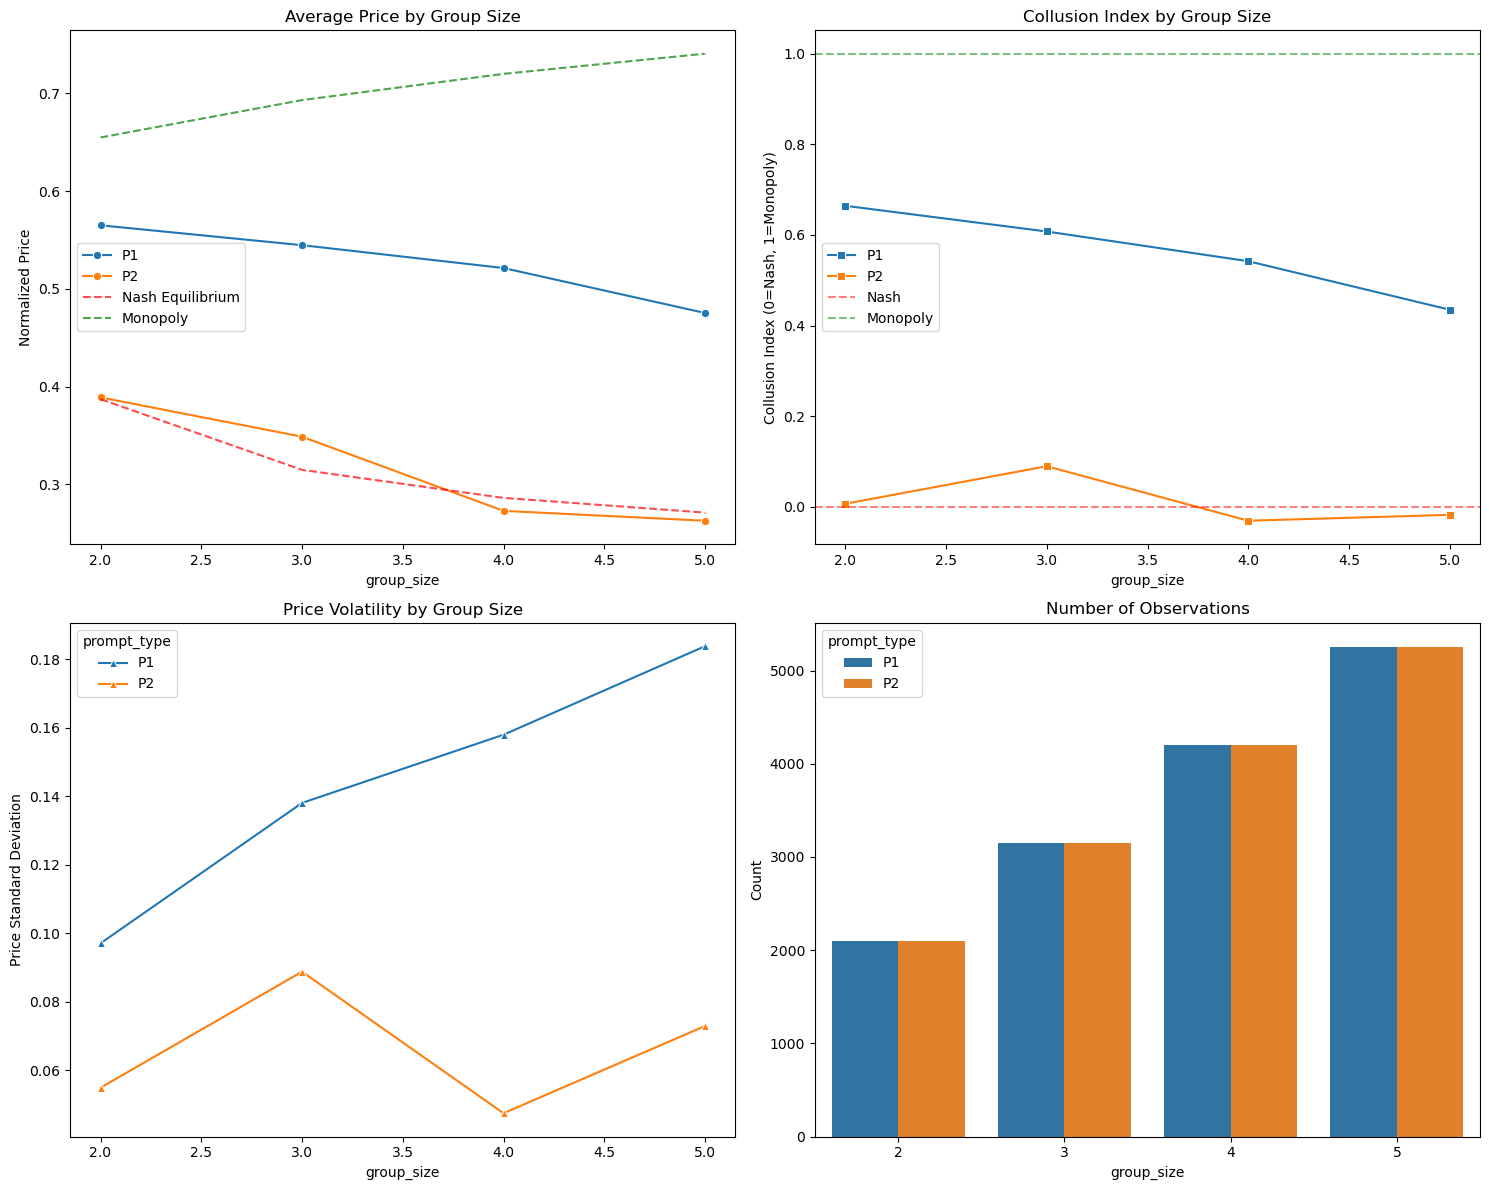

<Figure size 1200x800 with 0 Axes>

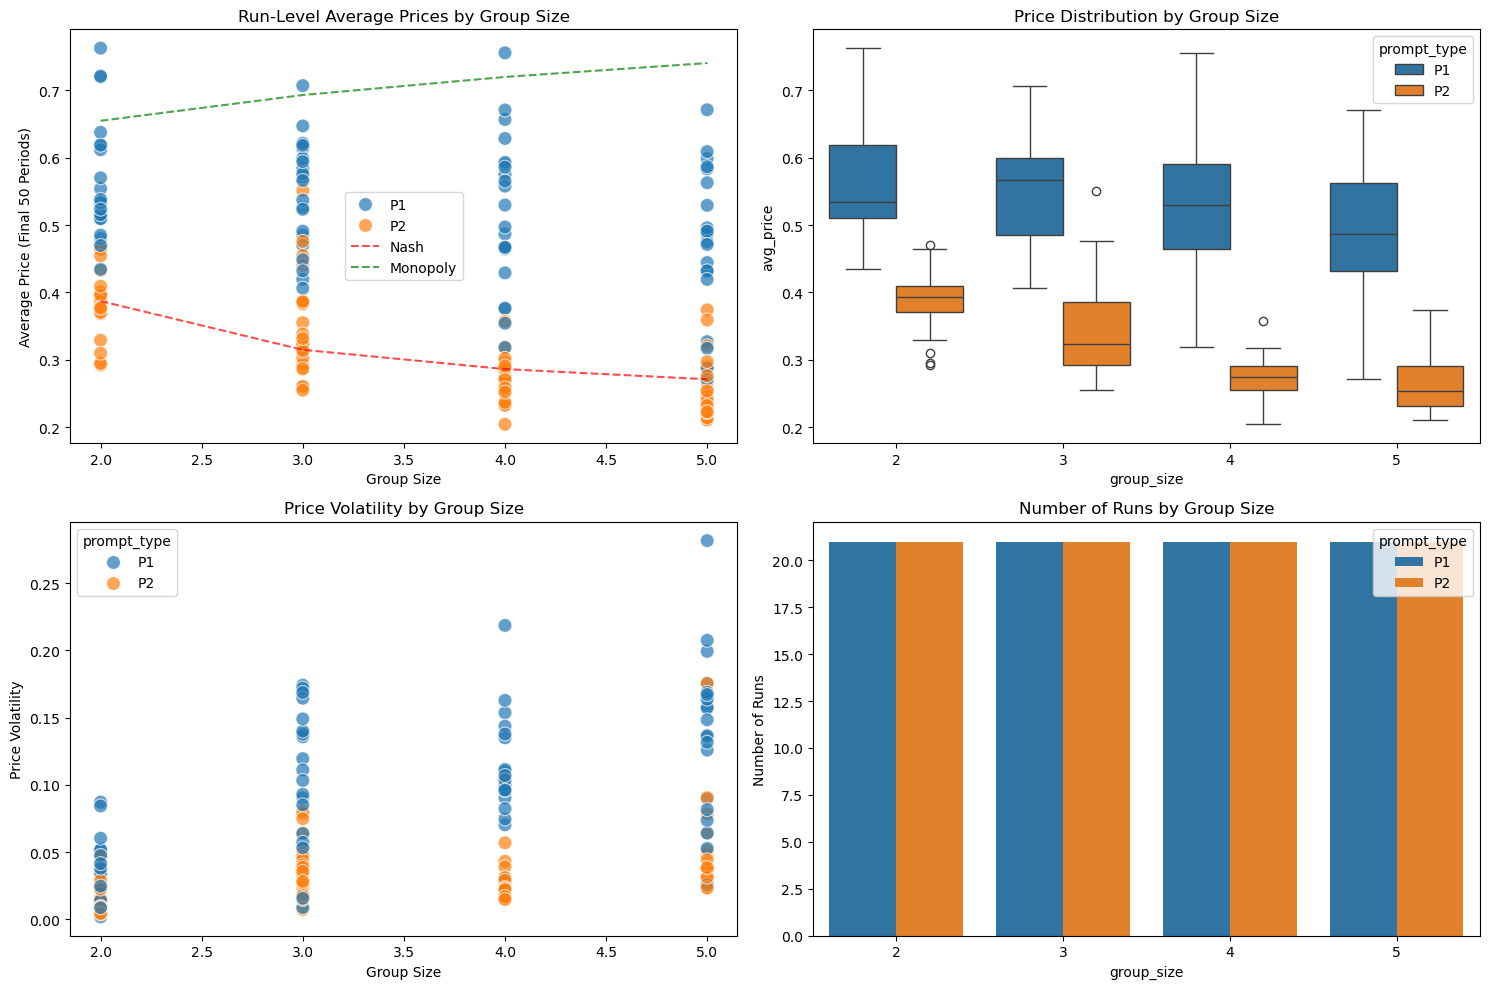

In [17]:
analysis.plot_results()

In [18]:
# Print summary
analysis.print_summary()


COLLUSION BREAKDOWN ANALYSIS - SUMMARY RESULTS

THEORETICAL BENCHMARKS BY GROUP SIZE:
----------------------------------------
Raw benchmarks (before normalization):
  Group Size 2: Nash=4.713, Monopoly=6.160, Alpha=3.200
  Group Size 2: Nash=14.729, Monopoly=19.250, Alpha=10.000
  Group Size 2: Nash=4.713, Monopoly=6.160, Alpha=3.200
  Group Size 2: Nash=1.473, Monopoly=1.925, Alpha=1.000
  Group Size 2: Nash=14.729, Monopoly=19.250, Alpha=10.000
  Group Size 2: Nash=1.473, Monopoly=1.925, Alpha=1.000
  Group Size 3: Nash=4.385, Monopoly=6.400, Alpha=3.200
  Group Size 3: Nash=13.702, Monopoly=20.000, Alpha=10.000
  Group Size 3: Nash=1.370, Monopoly=2.000, Alpha=1.000
  Group Size 3: Nash=4.385, Monopoly=6.400, Alpha=3.200
  Group Size 3: Nash=1.370, Monopoly=2.000, Alpha=1.000
  Group Size 3: Nash=1.370, Monopoly=2.000, Alpha=1.000
  Group Size 3: Nash=13.702, Monopoly=20.000, Alpha=10.000
  Group Size 3: Nash=13.702, Monopoly=20.000, Alpha=10.000
  Group Size 3: Nash=4.385, Monopo

AttributeError: 'DataFrame' object has no attribute 'summary'

# Overall Analysis Summary: Folk Theorem Evidence in Algorithmic Markets

## Executive Summary

This analysis provides **empirical evidence for the Folk Theorem** using agent rotation methodology. The key finding is that **collusion systematically breaks down as group size increases**, with a critical threshold around n=3 agents. However, the mechanism operates through **long-run equilibrium differences** rather than short-run strategic adjustments.

---

## Core Findings

### 🎯 **Folk Theorem: CONFIRMED**
- **Linear Effect**: Each additional competitor reduces prices by 0.055 units (5.5% effect)
- **Threshold Effect**: Groups ≤3 sustain 11.6% higher prices than larger groups  
- **Statistical Strength**: Both effects highly significant (p<0.001)

### ⚡ **Pricing Dynamics: Extreme Persistence**
- **Price Persistence**: 99.7% of previous period's price carries forward
- **Strategic Interaction**: Minimal response to competitor moves (0.03% effect)
- **Adjustment Process**: Near random-walk behavior with slow convergence

### 🧠 **Prompt Heterogeneity: Differential Collusion**
- **P1 Prompt**: Maintains substantial collusion even at n=5 (43% toward monopoly)
- **P2 Prompt**: Becomes hyper-competitive at n≥4 (below Nash equilibrium)
- **Consistent Folk Theorem**: Group size effects operate similarly under both prompts

---

## Methodological Insights

### 🔄 **Agent Rotation Success**
The sophisticated agent alternation methodology delivers:
- **Perfect Balance**: Equal representation across all agents and group sizes
- **Multi-Agent Support**: Seamless handling of 2-5 agent groups using average competitor approach
- **16,800 High-Quality Observations**: Substantial statistical power
- **No Simpson's Paradox**: Proper normalization prevents composition biases

### 📊 **Dynamic vs. Equilibrium Analysis**
The contrast between dynamic panel and run-level results reveals:

**Dynamic Panels** (non-significant group size effects):
- Capture period-to-period price adjustments
- Dominated by extreme price persistence (0.997)
- Minimal strategic interaction between periods
- Answer: "Does group size affect price changes?"

**Run-Level Analysis** (strong group size effects):  
- Capture equilibrium differences across group sizes
- Test true Folk Theorem predictions
- Avoid over-controlling with lagged prices
- Answer: "Do different group sizes reach different equilibrium prices?"

---

## Economic Interpretation

### 🎲 **Coordination Difficulty Mechanism**
As group size increases, tacit coordination becomes exponentially harder due to:
1. **Monitoring Costs**: Harder to track all competitors' behavior
2. **Focal Point Problem**: Difficult to coordinate on specific price levels  
3. **Punishment Sustainability**: Complex to maintain credible retaliation strategies
4. **Strategic Complexity**: Cognitive burden of multi-agent reasoning

### 🤖 **Algorithmic Agent Behavior**
AI agents exhibit patterns consistent with human experimental evidence:
- **Bounded Rationality**: Limited strategic sophistication in dynamic interactions
- **Focal Point Coordination**: Ability to achieve tacit coordination without communication
- **Folk Theorem Constraints**: Subject to same coordination limits as human players

## Conclusion

1. **Collusion systematically decreases with group size** (-5.5% per additional competitor)
2. **Critical thresholds exist around n=3** (+11.6% price premium for small groups)  
3. **Dynamic interactions are minimal** (99.7% price persistence, weak strategic responses)
4. **Prompt design significantly influences** the level but not the pattern of collusion
